# # MDD with 3D dataset - local reflection response visualization at depth level

### Author: M.Ravasi

This notebook is used to visualize the local reflection responses estimated at a chosen depth level for a grid of subsurface points produced by `MDD.py`.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import dask.array as da
import pylops
import pylops_distributed

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc
from dask.distributed import Scheduler, Client

from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *

from pylops.utils import dottest
from pylops_distributed.utils import dottest as ddottest
from pylops_distributed.optimization.cg import cg as dcg
from pylops_distributed.optimization.cg import cgls as dcgls

In [2]:
os.environ["STORE_PATH"] = "/project/fsenter/mrava/Marchenko3D/"

In [18]:
subsampling = 4

vsz = 650
nvsx = 71
dvsx = 20
ovsx = 200
nvsy = 41
dvsy = 20
ovsy = 200

ivsplot = 758

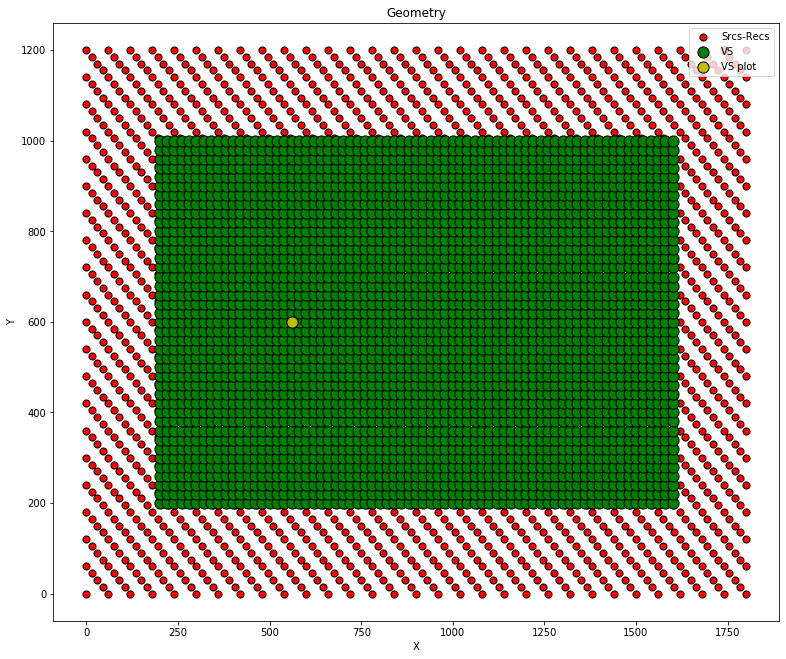

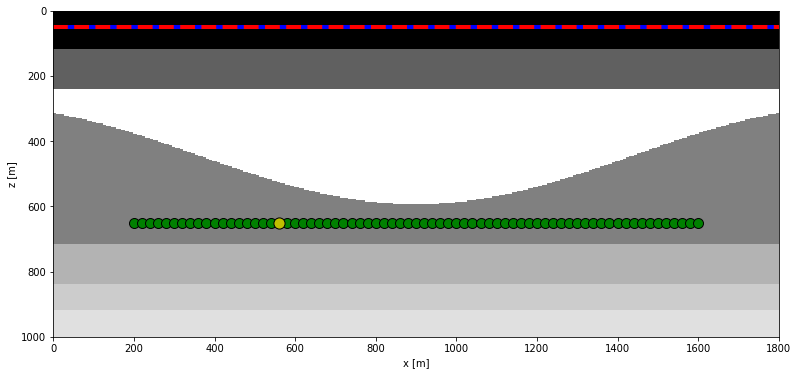

In [19]:
inputfile_aux = os.environ["STORE_PATH"] + '3DMarchenko_auxiliary_2.npz' 

# Load input
inputdata_aux = np.load(inputfile_aux)

# Receivers
r = inputdata_aux['recs'][::subsampling].T
nr = r.shape[1]
dr = r[0,1]-r[0,0]

# Sources
s = inputdata_aux['srcs'][::subsampling].T
ns = s.shape[1]
ds = s[0,1]-s[0,0]

# Virtual points
vsy = np.arange(nvsy) * dvsy + ovsy 
vsx = np.arange(nvsx) * dvsx + ovsx 
VSX, VSY = np.meshgrid(vsx, vsy, indexing='ij')

# Time axis
ot, dt, nt = 0, 2.5e-3, 601
t = np.arange(nt)*dt

# Density model
rho = inputdata_aux['rho']
z, x, y = inputdata_aux['z'], inputdata_aux['x'], inputdata_aux['y']

# Display geometry
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(13, 11))      
ax.scatter(r[0], r[1], marker='.', s=200, c='r', edgecolors='k', label='Srcs-Recs')
ax.scatter(VSX.ravel(), VSY.ravel(), marker='.', s=500, c='g', edgecolors='k', label='VS')
ax.scatter(VSX.ravel()[ivsplot:ivsplot+1], VSY.ravel()[ivsplot:ivsplot+1], marker='.', s=500, 
           c='y', edgecolors='k', label='VS plot')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Geometry')
plt.legend()
plt.show()

fig, ax1 = plt.subplots(1, 1, figsize=(13, 6))
ax1.imshow(rho[np.argmin(np.abs(y-VSY.ravel()[ivsplot]))].T, cmap='gray', vmin=1000, vmax=5000,
           extent = (x[0], x[-1], z[-1], z[0]))
ax1.axhline(r[2, 0], color='b', lw=4)
ax1.axhline(s[2, 0], color='r', linestyle='--', lw=4)
ax1.scatter(vsx, vsz * np.ones(nvsx), marker='.', s=400, c='g', edgecolors='k')
ax1.scatter(VSX.ravel()[ivsplot], vsz * np.ones(1), marker='.', s=500, c='y', edgecolors='k')
ax1.axis('tight')
ax1.set_xlabel('x [m]')
ax1.set_ylabel('z [m]')
ax1.set_xlim(x[0], x[-1]);

In [20]:
RSs_adj = da.from_zarr(os.environ["STORE_PATH"] + 'R_Ss_adj_sub%d.zarr' % subsampling)
RSs_inv = da.from_zarr(os.environ["STORE_PATH"] + 'R_Ss_inv_sub%d.zarr' % subsampling)

RMck_adj = da.from_zarr(os.environ["STORE_PATH"] + 'R_Mck_adj_sub%d.zarr' % subsampling)
RMck_inv = da.from_zarr(os.environ["STORE_PATH"] + 'R_Mck_inv_sub%d.zarr' % subsampling)

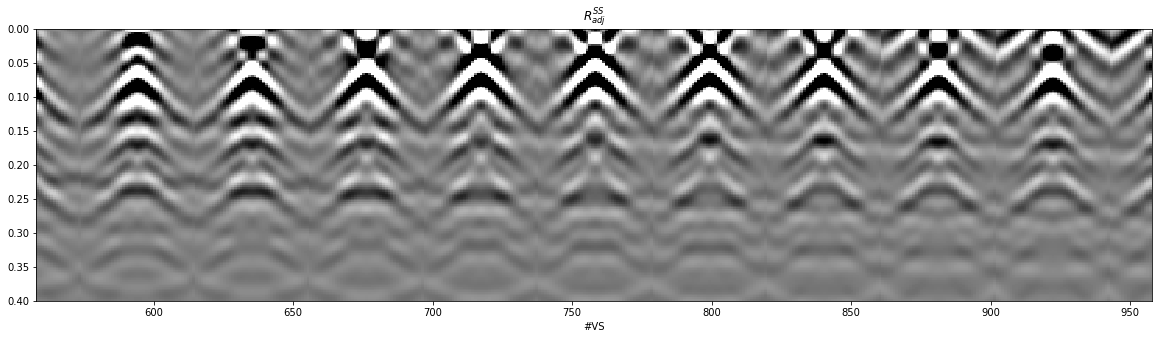

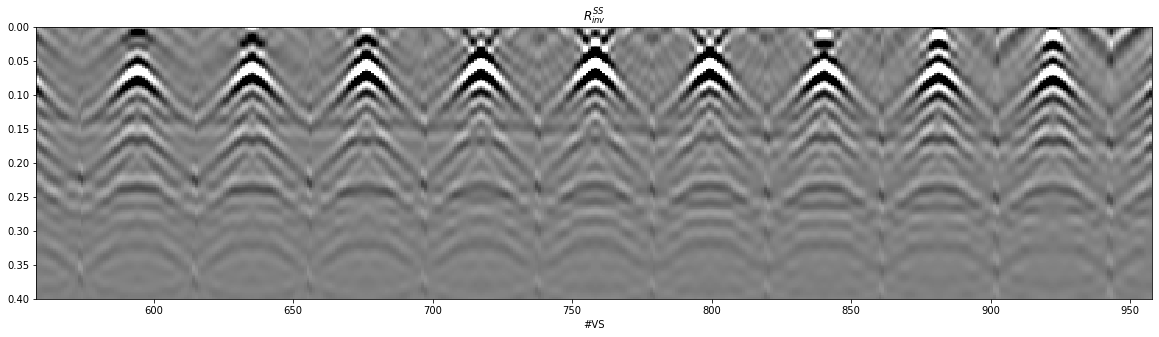

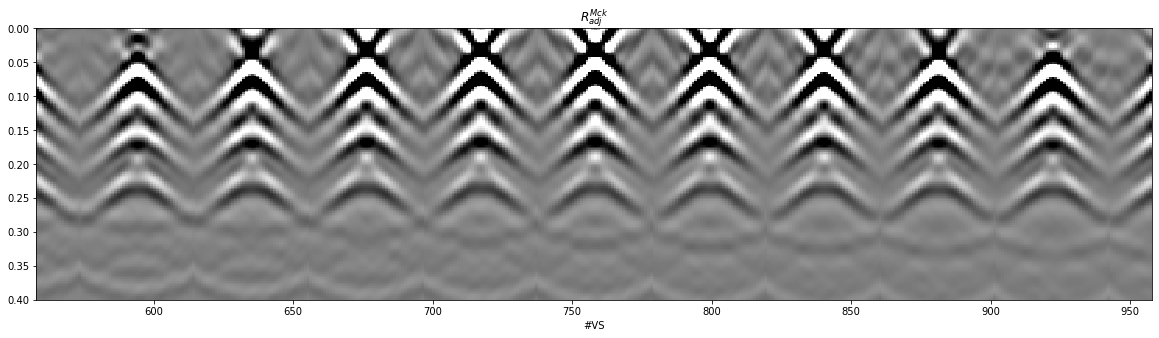

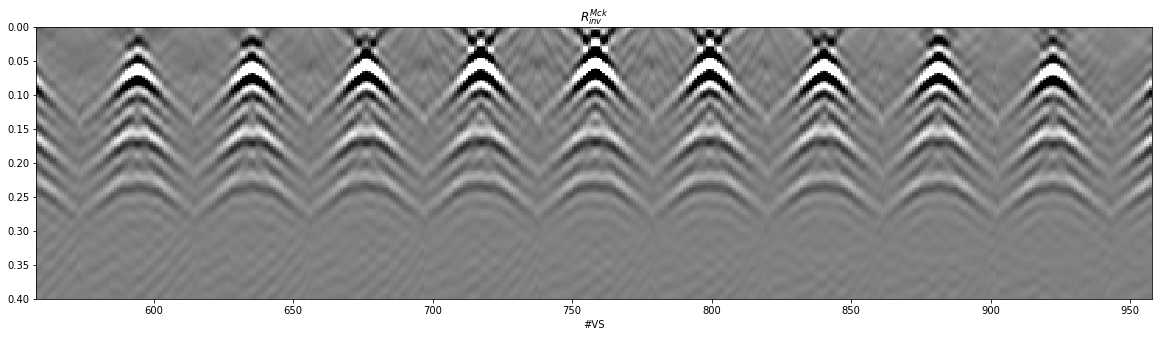

In [25]:
clip_adj = 5e-2
clip_inv = 1e-1

plt.figure(figsize=(20, 5))
plt.imshow(RSs_adj[..., ivsplot], cmap='gray',
           vmin=-clip_adj*RSs_adj.max(), vmax=clip_adj*RSs_adj.max(),
           extent=(0, nvsx*nvsy, t.max(), 0))
plt.axis('tight')
plt.title(r'$R^{SS}_{adj}$')
plt.xlabel('#VS')
plt.xlim(ivsplot-200, ivsplot+200)
plt.ylim(0.4, 0.)

plt.figure(figsize=(20, 5))
plt.imshow(RSs_inv[..., ivsplot], cmap='gray',
           vmin=-clip_inv*RSs_inv.max(), vmax=clip_inv*RSs_inv.max(),
           extent=(0, nvsx*nvsy, t.max(), 0))
plt.axis('tight')
plt.xlim(500, 900)
plt.title(r'$R^{SS}_{inv}$')
plt.xlabel('#VS')
plt.xlim(ivsplot-200, ivsplot+200)
plt.ylim(0.4, 0.)

plt.figure(figsize=(20, 5))
plt.imshow(RMck_adj[..., ivsplot], cmap='gray',
           vmin=-clip_adj*RMck_adj.max(), vmax=clip_adj*RMck_adj.max(),
           extent=(0, nvsx*nvsy, t.max(), 0))
plt.axis('tight')
plt.title(r'$R^{Mck}_{adj}$')
plt.xlabel('#VS')
plt.xlim(ivsplot-200, ivsplot+200)
plt.ylim(0.4, 0.)

plt.figure(figsize=(20, 5))
plt.imshow(RMck_inv[..., ivsplot], cmap='gray',
           vmin=-clip_inv*RMck_inv.max(), vmax=clip_inv*RMck_inv.max(),
           extent=(0, nvsx*nvsy, t.max(), 0))
plt.axis('tight')
plt.xlim(500, 900)
plt.title(r'$R^{Mck}_{inv}$')
plt.xlabel('#VS')
plt.xlim(ivsplot-200, ivsplot+200)
plt.ylim(0.4, 0.);


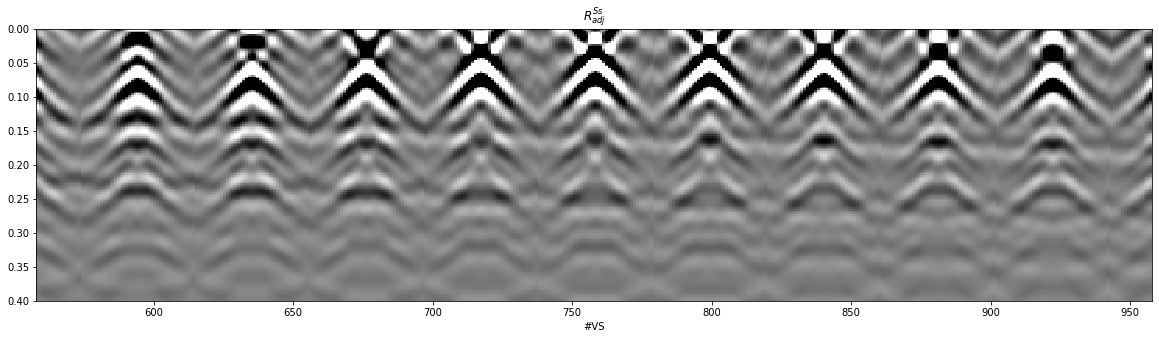

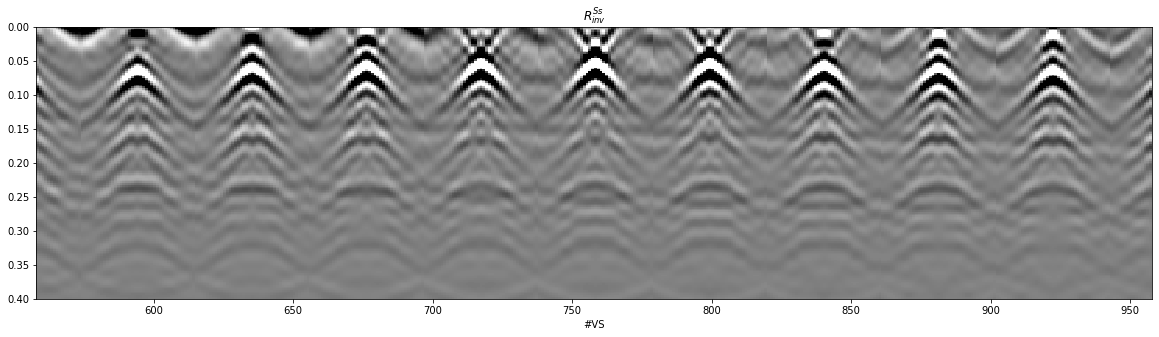

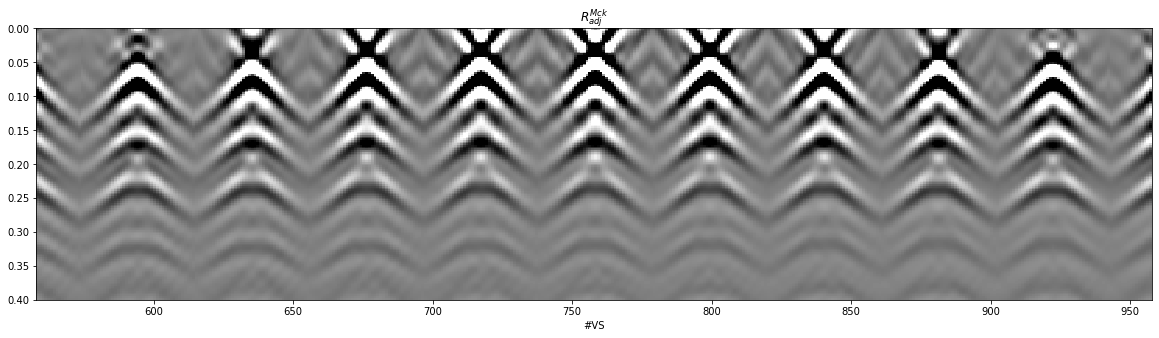

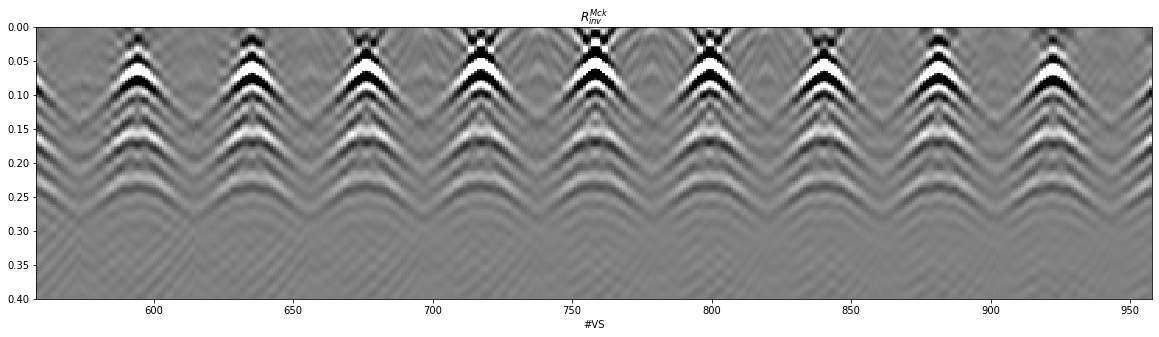

In [27]:
plt.figure(figsize=(20, 5))
plt.imshow(RSs_adj[:, ivsplot], cmap='gray',
           vmin=-clip_adj*RSs_adj.max(), vmax=clip_adj*RSs_adj.max(),
           extent=(0, nvsx*nvsy, t.max(), 0))
plt.axis('tight')
plt.title(r'$R^{Ss}_{adj}$')
plt.xlabel('#VS')
plt.xlim(ivsplot-200, ivsplot+200)
plt.ylim(0.4, 0)

plt.figure(figsize=(20, 5))
plt.imshow(RSs_inv[:, ivsplot], cmap='gray',
           vmin=-clip_inv*RSs_inv.max(), vmax=clip_inv*RSs_inv.max(),
           extent=(0, nvsx*nvsy, t.max(), 0))
plt.axis('tight')
plt.xlim(500, 900)
plt.title(r'$R^{Ss}_{inv}$')
plt.xlabel('#VS')
plt.xlim(ivsplot-200, ivsplot+200)
plt.ylim(0.4, 0)

plt.figure(figsize=(20, 5))
plt.imshow(RMck_adj[:, ivsplot], cmap='gray',
           vmin=-clip_adj*RMck_adj.max(), vmax=clip_adj*RMck_adj.max(),
           extent=(0, nvsx*nvsy, t.max(), 0))
plt.axis('tight')
plt.title(r'$R^{Mck}_{adj}$')
plt.xlabel('#VS')
plt.xlim(ivsplot-200, ivsplot+200)
plt.ylim(0.4, 0)

plt.figure(figsize=(20, 5))
plt.imshow(RMck_inv[:, ivsplot], cmap='gray',
           vmin=-clip_inv*RMck_inv.max(), vmax=clip_inv*RMck_inv.max(),
           extent=(0, nvsx*nvsy, t.max(), 0))
plt.axis('tight')
plt.xlim(500, 900)
plt.title(r'$R^{Mck}_{inv}$')
plt.xlabel('#VS')
plt.xlim(ivsplot-200, ivsplot+200)
plt.ylim(0.4, 0);